# GD1 Stream in Everest Data

## Gaia-GD1 Density Mixture Model

In [1]:
%pylab inline
import os
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import corner
import emcee

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from gala.dynamics import mockstream as ms
from astropy.io import fits
import astropy.units as u
from astropy.table import Table
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import scipy.interpolate

from scipy.stats import binned_statistic
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy import optimize, stats

from matplotlib.patches import Rectangle

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.coordinates import SkyCoord, ICRS, Galactocentric, galactocentric_frame_defaults
GCPARAMS = galactocentric_frame_defaults.get_from_registry("v4.0")['parameters']

In [3]:
plt.rc('font', size=14, family='serif')

In [4]:
pd.options.mode.chained_assignment = None

### Data

In [5]:
gd1 = pd.read_csv('gd1_cmd_cut.csv') #DESI Data

In [169]:
gaia_gd1 = pd.read_csv('gaia_gd1_cut.csv')
gaia_gd1 = gaia_gd1[gaia_gd1.CMD_cut]

In [9]:
phi2_poly = np.poly1d(np.load('/Users/pfagrelius/Research/DESI/MWS/Bonaca_PW/output/polytrack.npy'))

(-10.0, 10.0)

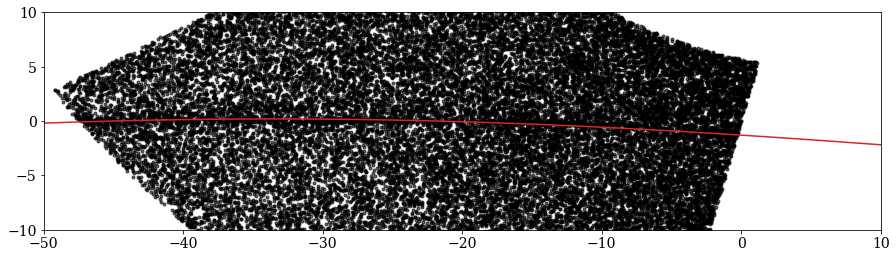

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(gaia_gd1.PHI1, gaia_gd1.PHI2, 
        marker='o', linewidth=0, ms=3,
        linestyle='none', alpha=0.6, c='k')

phi1_grid = np.linspace(-100, 20, 256)
ax.plot(phi1_grid, phi2_poly(phi1_grid), marker='', color='tab:red')


ax.set_xlim(-50, 10)
ax.set_ylim(-10, 10)

In [11]:
spur = gaia_gd1[(gaia_gd1.PHI1>-34)&(gaia_gd1.PHI1<-29)&(gaia_gd1.PHI2>-10)&(gaia_gd1.PHI2<10)]
blob = gaia_gd1[(gaia_gd1.PHI1>-18)&(gaia_gd1.PHI1<-13)&(gaia_gd1.PHI2>-10)&(gaia_gd1.PHI2<10)]
control = gaia_gd1[(gaia_gd1.PHI1>-46)&(gaia_gd1.PHI1<-41)&(gaia_gd1.PHI2>-10)&(gaia_gd1.PHI2<10)]

In [12]:
len(spur), len(blob), len(control)

(2715, 3497, 1564)

Text(0.5, 0, 'Stream Only')

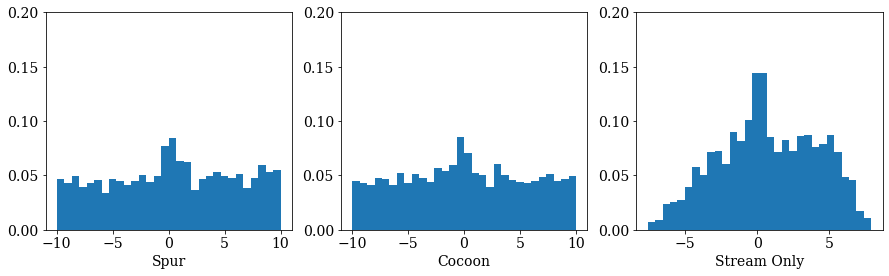

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
ax1.hist(spur.PHI2, bins=30, density=True, label='spur')
ax2.hist(blob.PHI2, bins=30, density=True, label='cocoon')
ax3.hist(control.PHI2, bins=30, density=True, label='stream only')
ax1.set_ylim(0,0.2)
ax2.set_ylim(0,0.2)
ax3.set_ylim(0,0.2)
ax1.set_xlabel('Spur')
ax2.set_xlabel('Cocoon')
ax3.set_xlabel('Stream Only')

### Mixture Model

In [170]:
phi1 = np.array(gaia_gd1.PHI1)
phi2 = np.array(gaia_gd1.PHI2)

In [171]:
phi2_max = 10.
phi2_min = -10
bin_size = 6
phi1_bins_l = np.arange(-50, 10-bin_size+1e-3, bin_size)
phi2_bins = np.arange(phi2_min, phi2_max+1e-3, 0.2)
phi2_grid = np.linspace(phi2_min, phi2_max, 256)

In [172]:
phi1_bins_l

array([-50., -44., -38., -32., -26., -20., -14.,  -8.,  -2.,   4.])

In [173]:
def lnnormal(x, mu, std):
    #return stats.norm.logpdf(x, loc=mu, scale=np.sqrt((10**lstd)**2))
    #return -0.5 * (((x-mu)**2 / (10**lstd)**2) + np.log(2*np.pi) + lstd)
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

In [198]:
def logmodel(p, phi2):
    (lna_s1, lna_s2, lna_f1, lna_f2, 
     mu_s, lnstd_s1, lnstd_s2, 
     mu_f1, lnstd_f1,
     mu_f2, lnstd_f2) = p
    
    (a_s1, a_s2, a_f1, a_f2) = np.exp([lna_s1, lna_s2, lna_f1, lna_f2])    
    a_bg = 1 - a_f1 - a_f2 - a_s1 - a_s2
    
    gd1 = lnnormal(phi2, mu_s, np.exp(lnstd_s1)) + lna_s1
    gd1_2 = lnnormal(phi2, mu_s, np.exp(lnstd_s2)) + lna_s2
    feat1 = lnnormal(phi2, mu_f1, np.exp(lnstd_f1)) + lna_f1
    feat2 = lnnormal(phi2, mu_f2, np.exp(lnstd_f2)) + lna_f2
    bg = np.full_like(gd1, -np.log(phi2_max - phi2_min)) + np.log(a_bg)
    
    args = [gd1, feat1, feat2, bg]
    return args

In [220]:
def loglike(p, phi2):
    (lna_s1, lna_s2, lna_f1, lna_f2, 
     mu_s, lnstd_s1, lnstd_s2, 
     mu_f1, lnstd_f1,
     mu_f2, lnstd_f2) = p

    (a_s1, a_s2, a_f1, a_f2) = np.exp([lna_s1, lna_s2, lna_f1, lna_f2])    
    a_bg = 1 - a_f1 - a_f2 - a_s1 - a_s2
    
    ##prior
    (a_s1, a_s2, a_f1, a_f2) = np.exp([lna_s1, lna_s2, lna_f1, lna_f2])
    
    fs = [a_f1, a_f2, a_s1, a_s2]
    for f in fs:
        if f < 0 or f > 1:
            return -np.inf
        
    if a_s2 > a_s1 or a_f1 > (a_s1+a_s2) or a_f2 > (a_s1+a_s2):
        return -np.inf
    
    if sum(fs) > 1:
        return -np.inf
    
    for mu in [mu_s, mu_f1, mu_f2]:
        if mu < -7.5 or mu > 4:
            return -np.inf
    
    #if mu_f1 > mu_s or mu_f2 < mu_s:
    #    return -np.inf
    
    args = logmodel(p, phi2)
    return logsumexp(args, axis=0)

def logprob(p, phi2):
    ll = loglike(p, phi2)
    if not np.all(np.isfinite(ll)):
        return -np.inf
    
    return ll.sum()

In [200]:
param_labels = [r'$\ln\alpha_{s, 1}$', r'$\ln\alpha_{s, 2}$', 
         r'$\ln\alpha_{f, 1}$', r'$\ln\alpha_{f, 2}$', 
         r'$\mu_s$', r'$\ln\sigma_{s, 1}$', r'$\ln\sigma_{s, 2}$',
         r'$\mu_{f, 1}$', r'$\ln\sigma_{f, 1}$',
         r'$\mu_{f, 2}$', r'$\ln\sigma_{f, 2}$']
def get_paramdict(theta):
    return OrderedDict(zip(param_labels, theta))

In [205]:
def plot_output(p, phi2_):
    params = get_paramdict(p)
    
    phi2_min = -10
    phi2_max = 10
    phi2arr = np.linspace(phi2_min, phi2_max, 25)
    
    ltot = loglike(p, phi2_grid)
    #gd1, gd1_2, feat1, feat2, bg = logmodel(p, phi2_grid)

    plt.hist(phi2_, density=True, color='grey',bins=phi2_bins)

    plt.plot(phi2_grid, np.exp(ltot), 'k-', lw=3)
#     plt.plot(phi2arr, np.exp(gd1,label='stream')
#     plt.plot(phi2arr, pfeature,label='feature')
#     plt.plot(phi2arr, pbg, label='bg')
    plt.legend()
    
    plt.show()

In [201]:
results = []
p0s = []
for l in phi1_bins_l:
    r = l+bin_size
    phi_mask = ((phi1 > l) & (phi1 <= r) & 
                (phi2 > -7.5))
    
    mu_s = phi2_poly(np.mean(phi1[phi_mask]))
    mu_f1 = mu_s - 1.
    mu_f2 = mu_s + 1.
    
    p0 = (np.log(0.4), np.log(0.1), np.log(0.1), np.log(0.1), 
          mu_s, np.log(0.2), np.log(0.3), 
          mu_f1, np.log(0.15),
          mu_f2, np.log(0.15))  
    p0s.append(p0)
    
    res = minimize(lambda *args: -logprob(*args), x0=p0, 
                   args=(phi2[phi_mask], ), method='L-BFGS-B')
    
    if res.success:
        results.append(res.x)
    else:
        print('failed')
        results.append(np.full_like(p0, np.nan))
        
# fig, ax = plt.subplots()
# ax.hist(phi2[phi_mask],
#         bins=phi2_bins, alpha=1, normed=True);

# ax.plot(phi2_grid, np.exp(lnlike(p0, phi2_grid)[0]), 
#         color='tab:green', marker='', alpha=0.6)
# ax.plot(phi2_grid, np.exp(lnlike(res.x, phi2_grid)[0]), 
#         color='tab:red', marker='', alpha=0.6)

results = np.array(results)
p0s = np.array(p0s)

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


failed


/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


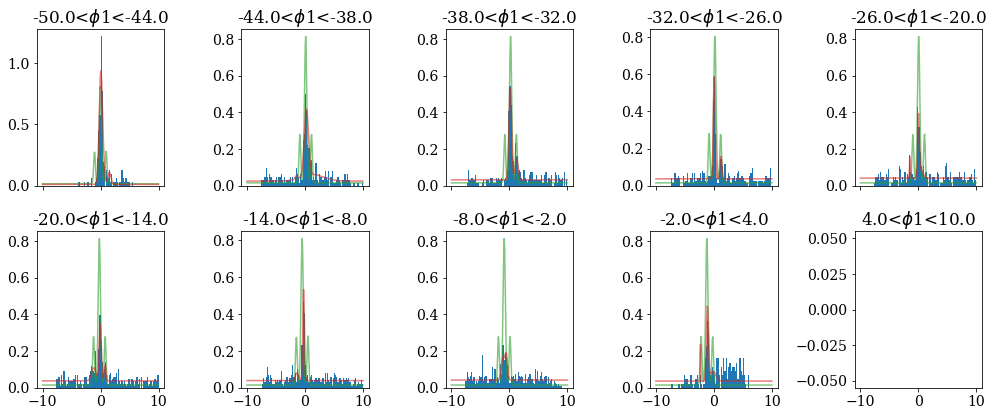

In [202]:
fig, axes = plt.subplots(2, 5, figsize=(14, 6), sharex=True)

for i, l in enumerate(phi1_bins_l):
    ax = axes.flat[i]
    
    r = l+bin_size
    phi_mask = ((phi1 > l) & (phi1 <= r) & 
                (phi2 > -7.5))
    
    
    ax.hist(phi2[phi_mask],
            bins=phi2_bins, alpha=1,density=True);
    
    p0 = p0s[i]
    res = results[i]
    ax.plot(phi2_grid, np.exp(loglike(p0, phi2_grid)), 
            color='tab:green', marker='', alpha=0.6)
    ax.plot(phi2_grid, np.exp(loglike(res, phi2_grid)), 
            color='tab:red', marker='', alpha=0.6)
    ax.set_title('{}<$\phi$1<{}'.format(l, r))
    
fig.tight_layout()

In [214]:
l = phi1_bins_l[3]
r = l+bin_size
phi_mask = ((phi1 > l) & (phi1 <= r))
phi2_ = phi2[phi_mask]
print(len(phi2_))

537


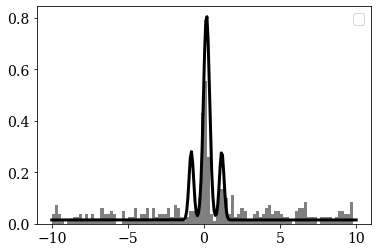

In [221]:
mu_s = phi2_poly(np.mean(phi1[phi_mask]))
mu_f1 = mu_s - 1.
mu_f2 = mu_s + 1.
    
p0_guess = (np.log(0.4), np.log(0.1), np.log(0.1), np.log(0.1), 
          mu_s, np.log(0.2), np.log(0.3), 
          mu_f1, np.log(0.15),
          mu_f2, np.log(0.15)) 

plot_output(p0_guess, phi2_)

In [222]:
optfunc = lambda *p: -logprob(*p)
result = optimize.minimize(optfunc, x0=p0_guess, args=(phi2_,),method='L-BFGS-B')

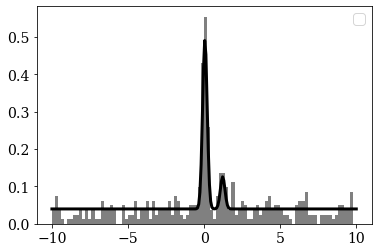

In [223]:
plot_output(result.x, phi2_)

In [224]:
nparams = len(param_labels)
print(nparams)
nwalkers = 64
p0 = result.x
ep0 = np.zeros(len(p0)) + 0.02 # some arbitrary width that's pretty close; scale accordingly to your expectation of the uncertainty
p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)
## Check to see things are initialized ok
lkhds = [logprob(p0s[j], phi2_) for j in range(nwalkers)]
assert np.all(np.array(lkhds) > -9e9)

11


In [225]:
sampler = emcee.EnsembleSampler(nwalkers, len(p0), logprob, args=(phi2_,))

In [226]:
state = sampler.run_mcmc(p0s, 4000)
sampler.reset()
_ = sampler.run_mcmc(state, 2048)

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in true_divide
  after removing the cwd from sys.path.
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after re

In [161]:
chain = sampler.chain

In [525]:
chain.shape

(64, 9, 11)

In [212]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

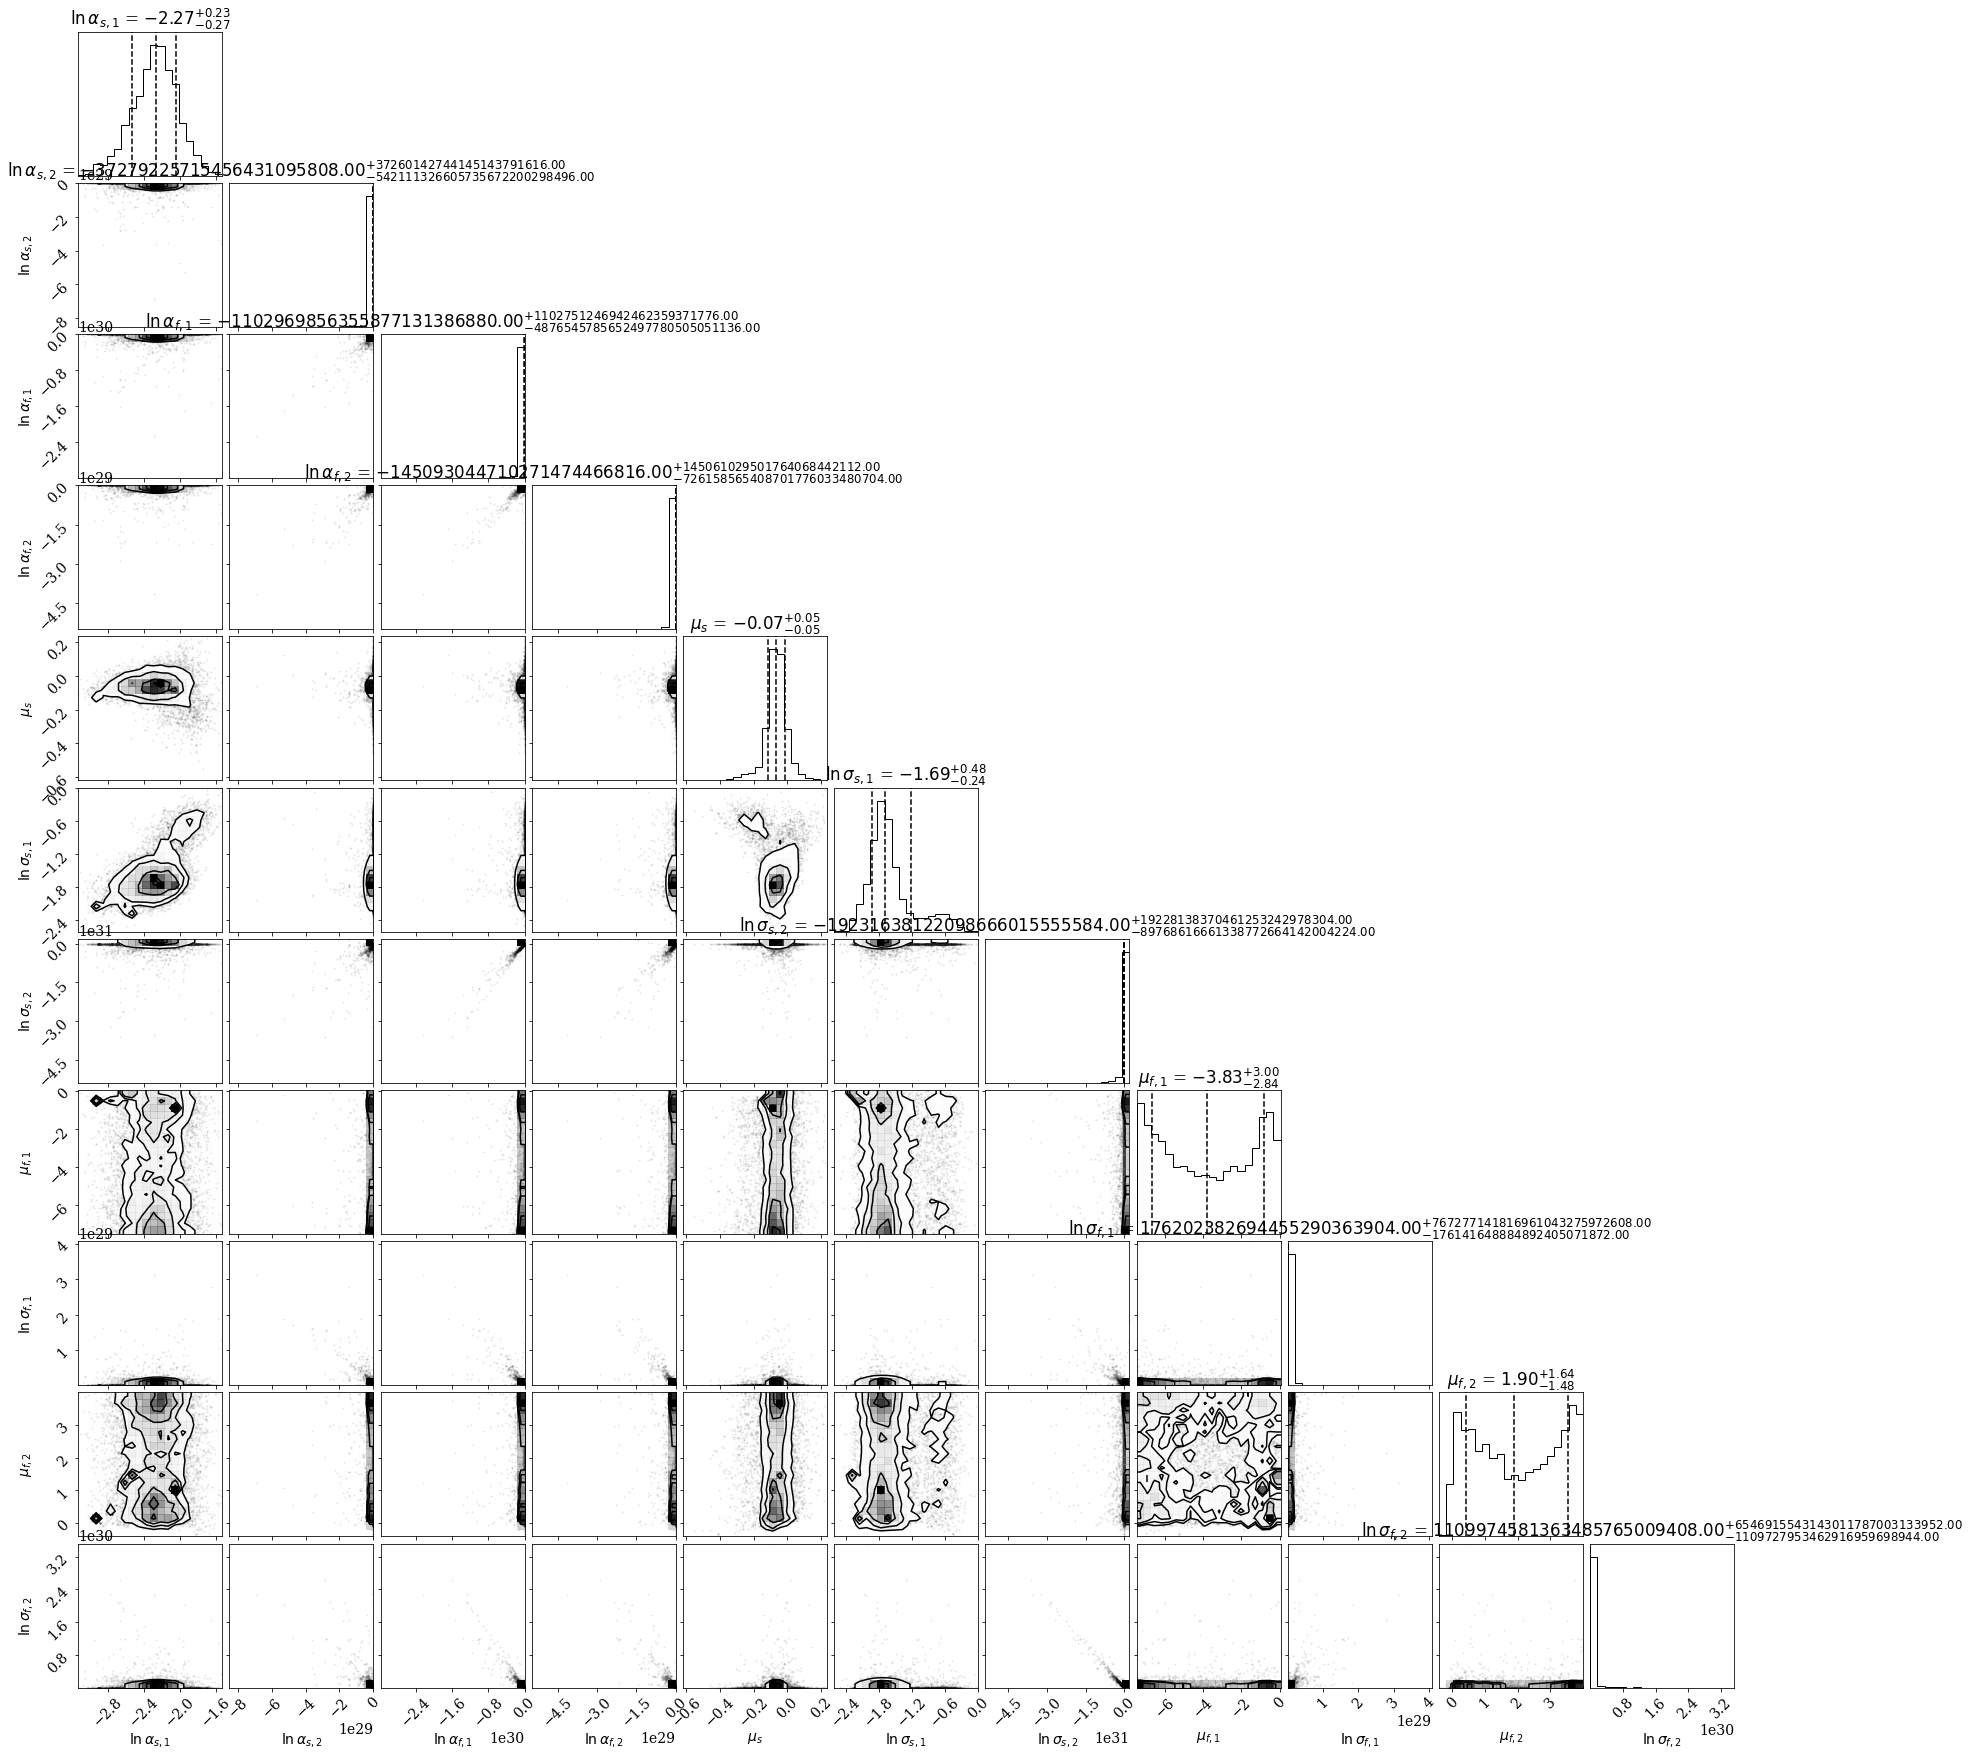

In [213]:
fig = corner.corner(flat_samples, labels=param_labels, quantiles=[0.16,0.50,0.84], show_titles=True)

In [364]:
def process_chain(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    meds = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error: # just for simplicity, assuming no asymmetry
        err = (ep-em)/2
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, err))
    else:
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, ep)), OrderedDict(zip(param_labels, em))

In [354]:
def get_stream_prob(sampler, phi_mask):
    norm = 0.0
    post_prob = np.zeros(phi_mask.sum())
    for i in range(sampler.chain.shape[1]):
        for j in range(sampler.chain.shape[0]):
            *ll_fg, ll_bg = sampler.blobs[i][j][0]
            ll_fg = logsumexp(ll_fg, axis=0)
            post_prob += np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
            norm += 1
    post_prob /= norm
    
    return post_prob

In [535]:
meds, errs = process_chain(flat_samples)

In [537]:
for k,v in meds.items():
    print('{}'.format(k), v, errs[k])

$\ln\alpha_{s, 1}$ 0.2997356918188907 0.01930317916881119
$\ln\alpha_{s, 2}$ -1.1992128583098864 0.02068692800504468
$\ln\alpha_{f, 1}$ -1.3839244850126489 0.020749426098859547
$\ln\alpha_{f, 2}$ 0.5003877416839837 0.020653131543253267
$\mu_s$ 2.997419708410833 0.01993328100181002
$\ln\sigma_{s, 1}$ 1.1017950080825094 0.02255378034290556
$\ln\sigma_{s, 2}$ -1.893192223264778 0.027377947296298943


In [538]:
plot_output(meds.values(), phi2_)

ValueError: not enough values to unpack (expected 11, got 7)

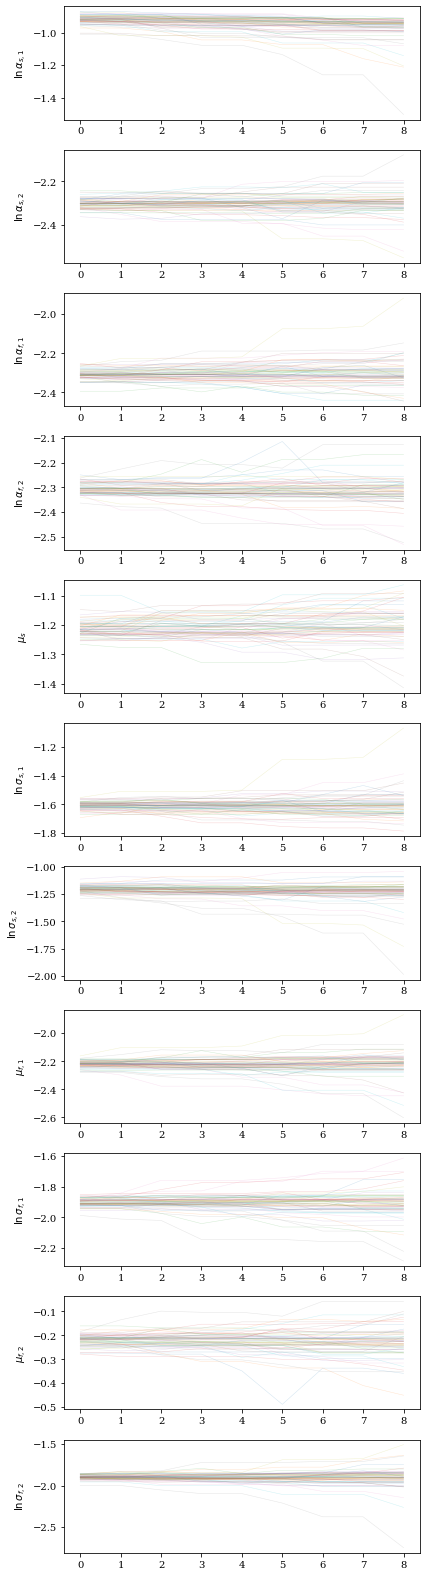

In [530]:
Nrow = chain.shape[2]
fig, axes = plt.subplots(Nrow, figsize=(6,2*Nrow))
for iparam,ax in enumerate(axes):
    for j in range(nwalkers):
        ax.plot(chain[j,:,iparam], lw=.5, alpha=.2)
        ax.set_ylabel(param_labels[iparam])
fig.tight_layout()

In [531]:
def get_stream_prob(sampler, phi_mask):
    norm = 0.0
    post_prob = np.zeros(phi_mask.sum())
    for i in range(sampler.chain.shape[1]):
        for j in range(sampler.chain.shape[0]):
            *ll_fg, ll_bg = sampler.blobs[i][j][0]
            ll_fg = logsumexp(ll_fg, axis=0)
            post_prob += np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
            norm += 1
    post_prob /= norm
    
    return post_prob

stream_prob = get_stream_prob(sampler, phi_mask)

In [533]:
high_prob_mask = np.zeros(len(phi1)).astype(bool)
low_prob_mask = np.zeros(len(phi1)).astype(bool)
all_stream_probs = np.zeros(len(phi1))
for i, phi_mask, stream_prob in zip(range(len(phi_masks)), phi_masks, stream_probs):
    high_prob_mask[phi_mask] = stream_prob > 0.50
    low_prob_mask[phi_mask] = stream_prob < 0.50
    all_stream_probs[phi_mask] = stream_prob

In [ ]:
g_stream_probs = np.zeros(len(g))
g_stream_probs[g.pm_mask & g.gi_cmd_mask] = all_stream_probs

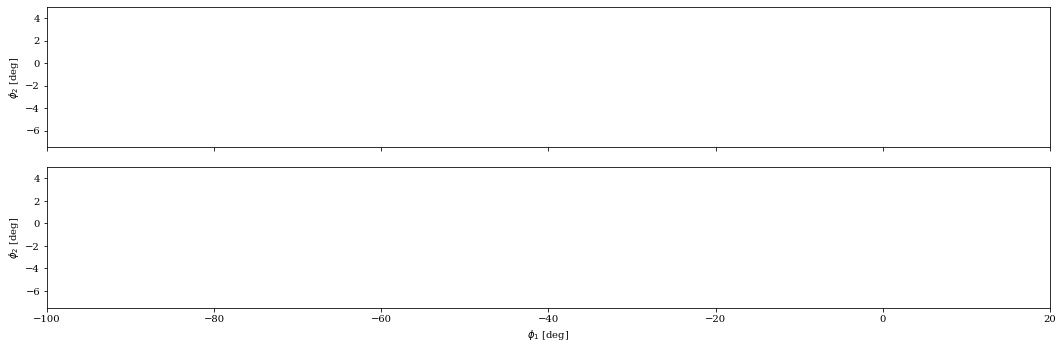

In [534]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharex=True, sharey=True)

for ax, mask in zip(axes, [low_prob_mask, high_prob_mask]):
    ax.plot(phi1[mask], phi2[mask], 
            marker='o', linewidth=0, ms=3,
            linestyle='none', alpha=0.6, c='k')

# phi1_grid = np.linspace(-100, 20, 256)
# ax.plot(phi1_grid, phi2_poly(phi1_grid), marker='', color='tab:red')

ax.set_xlim(-100, 20)
ax.set_ylim(-7.5, 5)

axes[0].set_ylabel(r'$\phi_2$ [deg]')
axes[1].set_ylabel(r'$\phi_2$ [deg]')
axes[1].set_xlabel(r'$\phi_1$ [deg]')

fig.tight_layout()
fig.set_facecolor('w')